In [1]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import *
from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Local imports
from unet import unet_cell, LEAKY_RELU_ALPHA, BATCH_NORM_MOMENTUM
from builders import build_upscaler_v2, build_discriminator
from utils import reduce_resolution

Using TensorFlow backend.


In [2]:
# Load MNIST training data
(X_train, _), (_, _) = mnist.load_data() # No need for labels or test set
X_train = X_train.reshape(-1, 28, 28, 1)
X_train = X_train / 255.0 # Normalize

In [3]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))
# TODO: dimensions of low_res_input should probably be divisible 
# by 2**{num_layers}
high_res_input = Input(shape=(None, None, 1)) # This should really have dimensions twice that of low_res_input

# Build upscaler / discriminator
upscaler = build_upscaler_v2(
    low_res_input,
    output_size=(28, 28),
    resize_method='nearest_neighbor',
    align_corners=True,
    num_filters_in_layer=[16, 32, 64, 32],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)
discriminator = build_discriminator(low_res_input, high_res_input) # Use default parameters

# Define optimizers and compile models
upscaler_optimizer = Adam(0.001, 0.5)
upscaler.compile(loss='binary_crossentropy', 
                 optimizer=upscaler_optimizer)

discriminator_optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=discriminator_optimizer, 
                      metrics=['accuracy'])

discriminator.trainable = False

upscaled_imgs = upscaler(low_res_input)
valid = discriminator([low_res_input, upscaled_imgs])

# The combined model  (stacked upscaler and discriminator) takes
# low-res image as input and returns an upsampled image from the 
# upscaler and a validity score given by the discriminator
combined = Model(low_res_input, [valid, upscaled_imgs])
combined.compile(loss=['binary_crossentropy', 'mean_absolute_error'], 
                 optimizer=upscaler_optimizer, 
                 metrics = ['accuracy'])
# Notice: the combined model was compiled *after* freezing the discriminator's weights

combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28, 1)    135047      input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            122097      input_1[0][0]                    
                                                                 model_1[1][0]                    
Total params: 257,144
Trainable params: 134,123
Non-trainable params: 123,021
__________________________________________________________________________________________________


In [4]:
# Define training parameters
train_steps = 1000
print_every_n_steps = 20
print_results = True
plot_results = True
batch_size = 200
half_batch = batch_size // 2

# Create a dictionary for storing training metrics over time
training_metrics = {
    'step': [],
    'd_loss': [],
    'd_acc': [],
    'g_loss': []
}

/opt/modules/devel/python/3.5.2/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 20:
    [D loss: 0.712110, accuracy: 0.5050]
    [G loss: 0.959760]


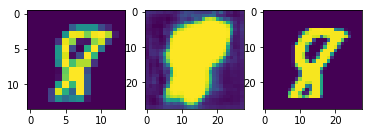

Step 40:
    [D loss: 0.702876, accuracy: 0.5200]
    [G loss: 0.898563]


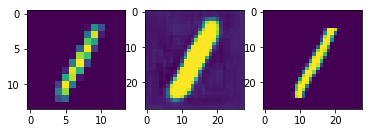

Step 60:
    [D loss: 0.697492, accuracy: 0.4900]
    [G loss: 0.856331]


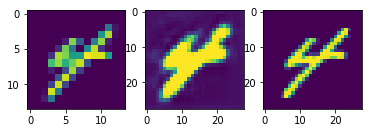

Step 80:
    [D loss: 0.696375, accuracy: 0.4750]
    [G loss: 0.821486]


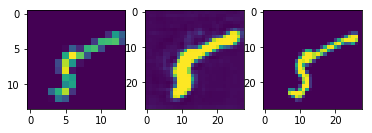

Step 100:
    [D loss: 0.696132, accuracy: 0.5050]
    [G loss: 0.798804]


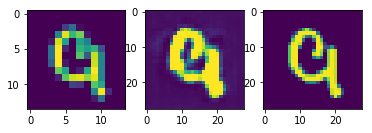

Step 120:
    [D loss: 0.694872, accuracy: 0.4900]
    [G loss: 0.781135]


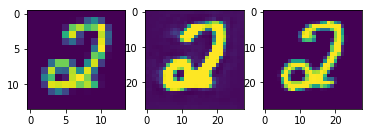

Step 140:
    [D loss: 0.694690, accuracy: 0.4850]
    [G loss: 0.764532]


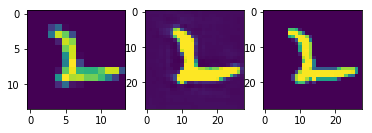

Step 160:
    [D loss: 0.694632, accuracy: 0.4800]
    [G loss: 0.754775]


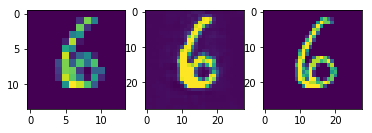

Step 180:
    [D loss: 0.694515, accuracy: 0.4650]
    [G loss: 0.748154]


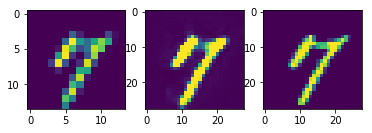

Step 200:
    [D loss: 0.694252, accuracy: 0.5050]
    [G loss: 0.740552]


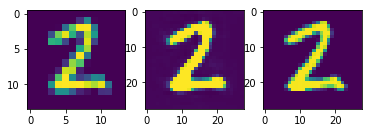

Step 220:
    [D loss: 0.694072, accuracy: 0.4900]
    [G loss: 0.736447]


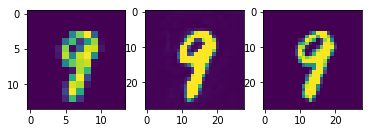

Step 240:
    [D loss: 0.694021, accuracy: 0.4900]
    [G loss: 0.732678]


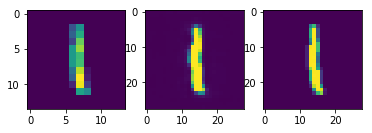

Step 260:
    [D loss: 0.693955, accuracy: 0.4900]
    [G loss: 0.730633]


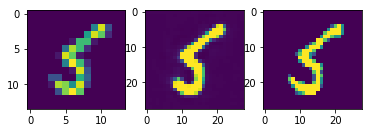

Step 280:
    [D loss: 0.693949, accuracy: 0.5250]
    [G loss: 0.728476]


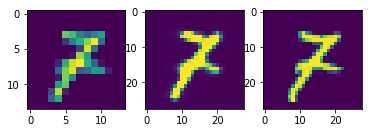

Step 300:
    [D loss: 0.693832, accuracy: 0.4950]
    [G loss: 0.724440]


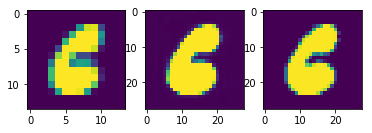

Step 320:
    [D loss: 0.693936, accuracy: 0.5100]
    [G loss: 0.721691]


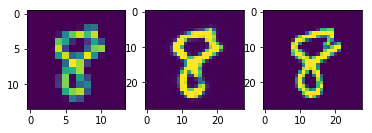

Step 340:
    [D loss: 0.693770, accuracy: 0.5250]
    [G loss: 0.720919]


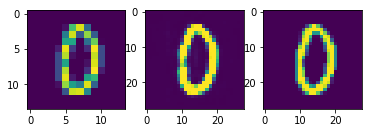

Step 360:
    [D loss: 0.693708, accuracy: 0.5200]
    [G loss: 0.719650]


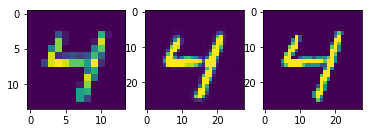

Step 380:
    [D loss: 0.693623, accuracy: 0.4700]
    [G loss: 0.719216]


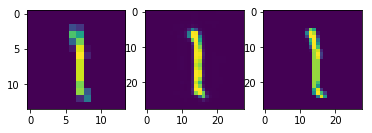

Step 400:
    [D loss: 0.693659, accuracy: 0.5200]
    [G loss: 0.718622]


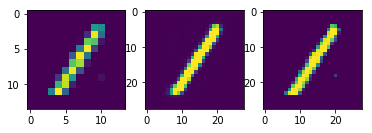

Step 420:
    [D loss: 0.693746, accuracy: 0.4850]
    [G loss: 0.716263]


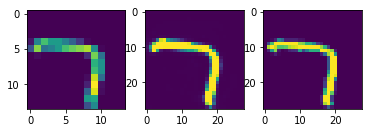

Step 440:
    [D loss: 0.693704, accuracy: 0.5300]
    [G loss: 0.716010]


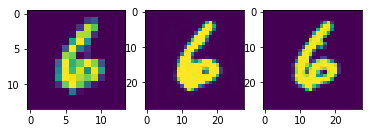

Step 460:
    [D loss: 0.693591, accuracy: 0.5250]
    [G loss: 0.715041]


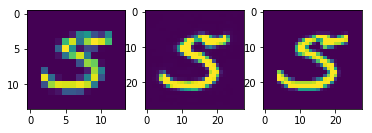

Step 480:
    [D loss: 0.693574, accuracy: 0.5150]
    [G loss: 0.715578]


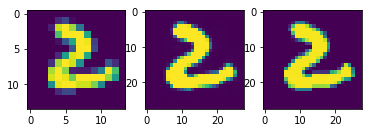

Step 500:
    [D loss: 0.693573, accuracy: 0.5050]
    [G loss: 0.714646]


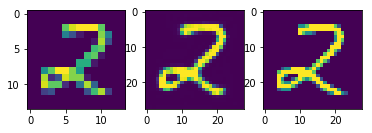

Step 520:
    [D loss: 0.693605, accuracy: 0.4850]
    [G loss: 0.713571]


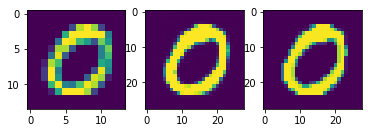

Step 540:
    [D loss: 0.693530, accuracy: 0.4800]
    [G loss: 0.713178]


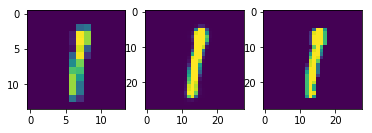

Step 560:
    [D loss: 0.693602, accuracy: 0.5200]
    [G loss: 0.712597]


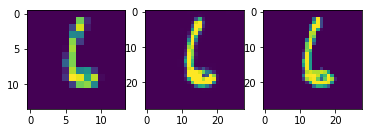

Step 580:
    [D loss: 0.693563, accuracy: 0.4950]
    [G loss: 0.712196]


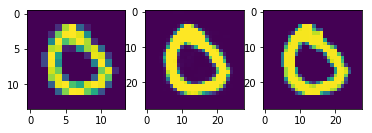

Step 600:
    [D loss: 0.693539, accuracy: 0.5200]
    [G loss: 0.711738]


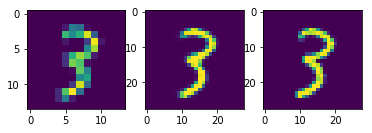

Step 620:
    [D loss: 0.693533, accuracy: 0.5000]
    [G loss: 0.712150]


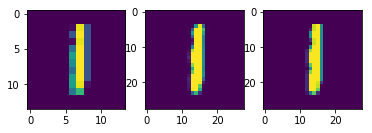

Step 640:
    [D loss: 0.693592, accuracy: 0.5050]
    [G loss: 0.712515]


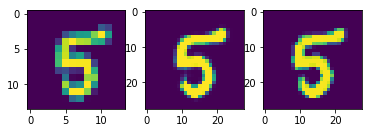

Step 660:
    [D loss: 0.693494, accuracy: 0.5000]
    [G loss: 0.711011]


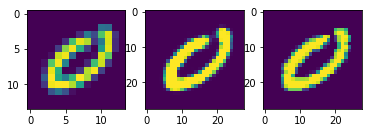

Step 680:
    [D loss: 0.693527, accuracy: 0.4750]
    [G loss: 0.710579]


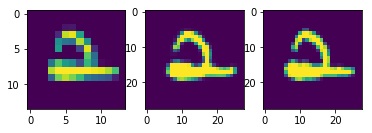

Step 700:
    [D loss: 0.693503, accuracy: 0.4800]
    [G loss: 0.710217]


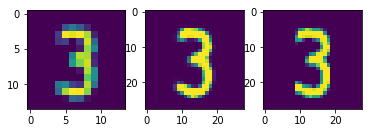

Step 720:
    [D loss: 0.693467, accuracy: 0.4750]
    [G loss: 0.710479]


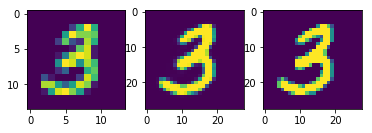

Step 740:
    [D loss: 0.693474, accuracy: 0.4750]
    [G loss: 0.710263]


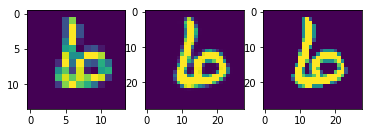

Step 760:
    [D loss: 0.693490, accuracy: 0.5200]
    [G loss: 0.710047]


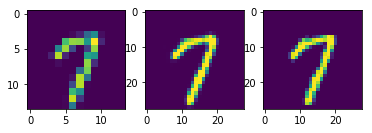

Step 780:
    [D loss: 0.693424, accuracy: 0.5050]
    [G loss: 0.709969]


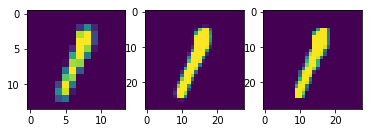

Step 800:
    [D loss: 0.693456, accuracy: 0.4850]
    [G loss: 0.709078]


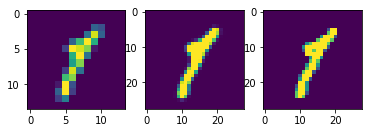

Step 820:
    [D loss: 0.693452, accuracy: 0.4400]
    [G loss: 0.710272]


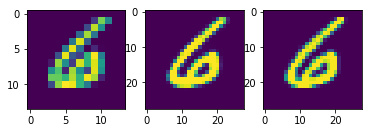

Step 840:
    [D loss: 0.693449, accuracy: 0.5250]
    [G loss: 0.709459]


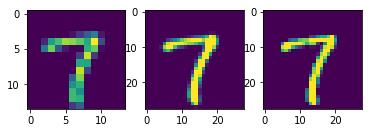

Step 860:
    [D loss: 0.693459, accuracy: 0.5050]
    [G loss: 0.709070]


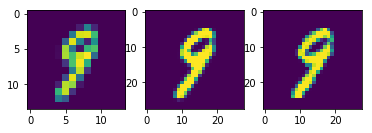

Step 880:
    [D loss: 0.693419, accuracy: 0.5300]
    [G loss: 0.710492]


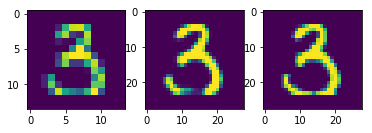

Step 900:
    [D loss: 0.693443, accuracy: 0.4800]
    [G loss: 0.708876]


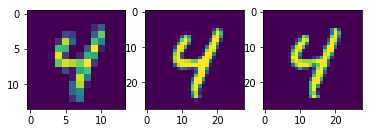

Step 920:
    [D loss: 0.693424, accuracy: 0.4950]
    [G loss: 0.708901]


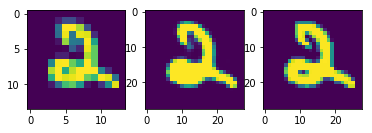

Step 940:
    [D loss: 0.693418, accuracy: 0.4500]
    [G loss: 0.709949]


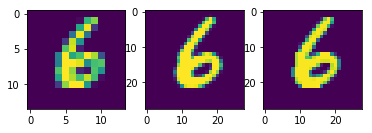

Step 960:
    [D loss: 0.693396, accuracy: 0.4850]
    [G loss: 0.708983]


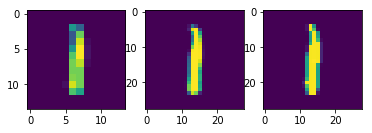

Step 980:
    [D loss: 0.693408, accuracy: 0.5250]
    [G loss: 0.708638]


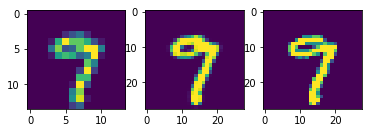

Step 1000:
    [D loss: 0.693432, accuracy: 0.5000]
    [G loss: 0.708541]


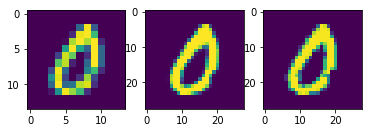

In [5]:
for step in range(1, train_steps + 1):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    num_images = len(X_train)
    random_idxs = np.random.randint(num_images, size=half_batch)
    real_imgs = X_train[random_idxs]
    low_res_real_imgs = reduce_resolution(real_imgs)

    random_idxs = np.random.randint(num_images, size=half_batch)
    imgs_for_upscaler = X_train[random_idxs]
    low_res_imgs = reduce_resolution(imgs_for_upscaler)

    # Generate a half batch of upsampled images
    gen_imgs = upscaler.predict(low_res_imgs)
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(
        x=[low_res_real_imgs, real_imgs], # Training data
        y=np.ones(shape=(half_batch, 1))) # Labels
    
    d_loss_fake = discriminator.train_on_batch(
        x=[low_res_imgs, gen_imgs],        # Training data
        y=np.zeros(shape=(half_batch, 1))) # Labels
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train upscaler
    # ---------------------

    random_idxs = np.random.randint(num_images, size=batch_size)
    original_imgs = X_train[random_idxs]
    new_low_res_imgs = reduce_resolution(original_imgs)

    # The upscaler wants the discriminator to label the generated 
    # samples as valid (ones)
    valid_y = np.array([1] * batch_size)
    
    # Train the upscaler
    g_loss = combined.train_on_batch(
        x=new_low_res_imgs, 
        y=[valid_y, original_imgs])
        
    if step % print_every_n_steps == 0:
        # Store metrics over time
        training_metrics['step'].append(step)
        training_metrics['d_loss'].append(d_loss[0])
        training_metrics['d_acc'].append(d_loss[1])
        training_metrics['g_loss'].append(g_loss[0])
        
        # Print current metrics
        if print_results:
            print("Step {}:".format(step))
            print("    [D loss: {:0.6f}, accuracy: {:0.4f}]".format(
                training_metrics['d_loss'][-1],
                training_metrics['d_acc'][-1]))
            print("    [G loss: {:0.6f}]".format(
                training_metrics['g_loss'][-1]))
        
        # Plot example low_res vs upsampling vs original
        if plot_results:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(low_res_imgs[0, :, :, 0])
            ax2.imshow(gen_imgs[0, :, :, 0])
            ax3.imshow(imgs_for_upscaler[0, :, :, 0])
            plt.show()

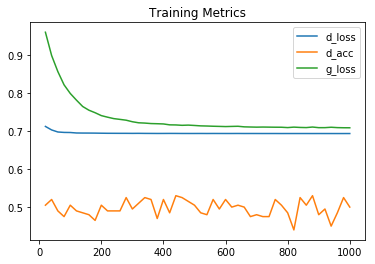

In [6]:
steps = training_metrics['step']
for key, values in training_metrics.items():
    if key == 'step': continue
    plt.plot(steps, values, label=key)
plt.title('Training Metrics')
plt.legend();

In [7]:
def save_models():
    upscaler.save('./models/upscaler_mnist.h5')
    discriminator.save('./models/discriminator_mnist.h5')
    combined.save('./models/combined_mnist.h5')

In [8]:
def show_examples():
    from keras.models import load_model

    # Load the upscaler
    upscaler = load_model('./models/upscaler_mnist.h5')

    # Upsample five images
    fi = 314 # First index
    images = X_train[fi:fi + 5]
    upsampled = upscaler.predict(images)
    upupsampled = upscaler.predict(upsampled)

    # Create a figure showing the results
    for i, (original, up, upup) in enumerate(zip(images, upsampled, upupsampled)):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        if i == 0:
            fig.suptitle("Original vs Upsampled vs Twice Upsampled")
        ax1.imshow(original[:, :, 0])
        ax2.imshow(up[:, :, 0])
        ax3.imshow(upup[:, :, 0])
        plt.show()

In [9]:
# save_models()
# show_examples()

# Transfering weights to model that produces larger outputs

In [10]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))

# Build upscaler with different output size
new_upscaler = build_upscaler_v2(
    low_res_input,
    output_size=(128, 128),  # Previous output size was (28, 28)
    resize_method='bicubic', # Notice: We've even changed resize method from NN to bicubic
    align_corners=True,
    num_filters_in_layer=[16, 32, 64, 32],
    num_cells_in_layer=[3, 3, 3, 3],
    bottleneck_before_concat=True)

# Compile the new upscaler
new_upscaler_optimizer = Adam(0.001, 0.5)
new_upscaler.compile(loss='binary_crossentropy', 
                     optimizer=new_upscaler_optimizer)

# Transfer weights from original upscaler to new upscaler
for new_layer, pretrained_layer in zip(new_upscaler.layers, upscaler.layers):
    learned_weights = pretrained_layer.get_weights()
    new_layer.set_weights(learned_weights)

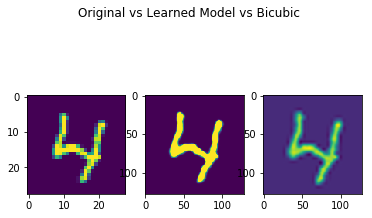

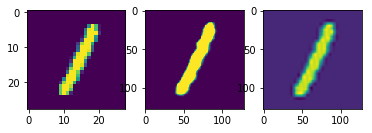

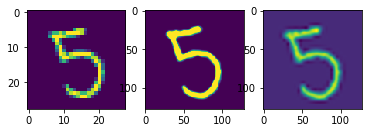

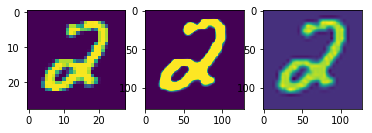

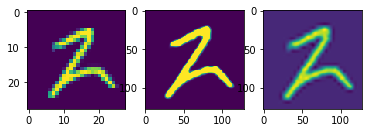

In [11]:
fi = 314 # First index
images = X_train[fi:fi+5] # Select five images
upsampled = new_upscaler.predict(images)

# Compare our model to vanilla bicubic resize:
with tf.Session() as sess:
    bicubic = sess.run(tf.image.resize_bicubic(images, (128, 128), align_corners=True))

# Create a figure showing the results
for i, (original, up, control) in enumerate(zip(images, upsampled, bicubic)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    if i == 0:
        fig.suptitle("Original vs Learned Model vs Bicubic")
    ax1.imshow(original[:, :, 0])
    ax2.imshow(up[:, :, 0])
    ax3.imshow(control[:, :, 0])
    plt.show()